# Exploring ensembling different sized models on uncertainty measures 

In [32]:
import pandas as pd
import numpy as np
from scipy.special import rel_entr
from scipy.stats import entropy
import matplotlib.pyplot as plt
from matplotlib_venn import venn3,venn2

In [33]:
# Load data:
df18 = pd.read_csv("../exp2-inf/predictions_res18_2.csv")
df101 = pd.read_csv("../exp2-inf/predictions_res101_2.csv")
label = pd.read_csv("../exp2-inf/labels.csv")
num_class = 257
pred = pd.DataFrame({
    "pred18": np.argmax(df18,axis=1),
    "pred101": np.argmax(df101,axis=1),
    "target": label['target']
})
print(f"{df18.shape=}")
display(df18.head(1))
print(f"{df101.shape=}")
display(df101.head(1))
print(f"{pred.shape=}")
display(pred.head(1))

df18.shape=(6122, 257)


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_247,class_248,class_249,class_250,class_251,class_252,class_253,class_254,class_255,class_256
0,0.002548,0.003643,0.002167,0.006165,0.00484,0.00836,0.002376,0.010965,0.002399,0.008175,...,0.001317,0.002514,0.006182,0.004792,0.004116,0.004633,0.002666,0.001376,0.006288,0.002184


df101.shape=(6122, 257)


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_247,class_248,class_249,class_250,class_251,class_252,class_253,class_254,class_255,class_256
0,0.000012,0.000211,0.00002,0.000049,0.00007,0.000075,0.000084,0.000053,0.00004,0.000068,...,0.000061,0.000053,0.000035,0.000057,0.000019,0.000117,0.000091,0.000042,0.000036,0.000246


pred.shape=(6122, 3)


,pred18,pred101,target
0,24,24,24


In [34]:
def eval_pred(pred):
    for col in pred.columns.drop("target"):
        acc = (pred[col]==pred["target"]).mean()
        print(f"{col} has accuracy {acc}")
eval_pred(pred)

pred18 has accuracy 0.7535119242077752
pred101 has accuracy 0.8694870957203529


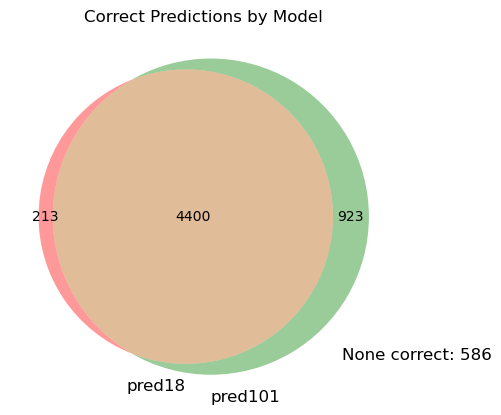

In [35]:
def venn(pred):
    # Accuracy Venn Diagram:
    df = pred
    ls = []
    total_indices = set(df.index)
    incorrect_all = total_indices
    col_names=[]
    for col in df.columns.drop("target"):
        col_names.append(col)
        cor_set = set(df[df[col] == df['target']].index)
        ls.append(cor_set)
        incorrect_all = incorrect_all - cor_set
    plt.figure(figsize=(5,5))
    if len(col_names)==2:
        venn2(ls, col_names)
    elif len(col_names)==3:
        venn3(ls, col_names)
    else:
        raise Exception("Matplotlib Venn only supports 2 or 3 sets, please subset to 3 predictions columns and target.")
    plt.title('Correct Predictions by Model')
    plt.text(0.5, -0.5, f'None correct: {len(incorrect_all)}', fontsize=12)
venn(pred)

# Approach 1: Classical Voting
**Hard Voting (Plurality Voting)**: Selecting the class that receives the most votes as the final prediction. The problem with hard voting here is that we only have two models.  
**Soft Voting (Weighted Voting with uniform weights)**: Calculates the average probability of each class and then declares the winner having the highest weighted probability.  
**Weighted Voting (with validation accuracy as weights)**: Calculates weighted probability of each class based on validation accuracy, and then selecting the class with highest weighted probability

In [36]:
# Soft Voting
def soft_vote(pred1, pred2):
    sum_pred = pred1+pred2
    return np.argmax(sum_pred,axis=1)
pred["soft_vote"] = soft_vote(df18, df101)
display(pred.head(1))
eval_pred(pred)

,pred18,pred101,target,soft_vote
0,24,24,24,24


pred18 has accuracy 0.7535119242077752
pred101 has accuracy 0.8694870957203529
soft_vote has accuracy 0.8742241097680497


In [37]:
# Soft Voting
def weighted_vote(pred1, pred2, weight1, weight2):
    weighted_pred = np.multiply(weight1,pred1)+np.multiply(weight2,pred2)
    return np.argmax(weighted_pred,axis=1)
pred["weighted_vote"] = weighted_vote(df18, df101, 0.75, 0.87)
display(pred.head(1))
eval_pred(pred)

,pred18,pred101,target,soft_vote,weighted_vote
0,24,24,24,24,24


pred18 has accuracy 0.7535119242077752
pred101 has accuracy 0.8694870957203529
soft_vote has accuracy 0.8742241097680497
weighted_vote has accuracy 0.873734073832081


# Approach 2: Uncertainty Voting
We propose an alternative aggregation strategy based on KL Divergence, Entropy, and Cross Entropy among the two models.

In [38]:
# Generate 2 KL Columns, 2 Entropy Columns, 2 Cross-Entropy Columns
unc_pred = pred.copy()
def calc_kl(P,Q,numclass):
    return rel_entr(P.iloc[:,0:numclass],Q.iloc[:,0:numclass]).sum(1)
unc_pred["kl_18_101"] = calc_kl(df18,df101,num_class)
unc_pred["kl_101_18"] = calc_kl(df101,df18,num_class)
def calc_entropy(P,numclass):
    return entropy(P.iloc[:,0:numclass],axis=1)
unc_pred["ent_18"] = calc_entropy(df18,num_class)
unc_pred["ent_101"] = calc_entropy(df101,num_class)
def calc_cross_ent(P,Q,numclass):
    return np.log(entropy(P.iloc[:,0:numclass],Q.iloc[:,0:numclass],axis=1))
unc_pred["ce_18_101"] = calc_cross_ent(df18,df101,num_class)
unc_pred["ce_101_18"] = calc_cross_ent(df18,df101,num_class)
unc_pred.head()

,pred18,pred101,target,soft_vote,weighted_vote,kl_18_101,kl_101_18,ent_18,ent_101,ce_18_101,ce_101_18
0,24,24,24,24,24,4.241348,3.726702,5.372475,0.360979,1.444881,1.444881
1,77,77,77,77,77,1.413814,0.609247,3.329311,0.519544,0.346291,0.346291
2,252,252,252,252,252,0.005484,0.008508,0.077559,0.125732,-5.205966,-5.205966
3,144,144,144,144,144,0.064559,0.032851,0.580312,0.176968,-2.740175,-2.740175
4,224,224,224,224,224,1.262630,0.503336,3.061391,0.243561,0.233197,0.233197


**Method 1** We select the prediction of the model with lower entropy (i.e. lower uncertainty) This is a flavor of hard voting, as in it is not going to predict anything that isn't already a top prediction of either model.

pred18 has accuracy 0.7535119242077752
pred101 has accuracy 0.8694870957203529
soft_vote has accuracy 0.8742241097680497
weighted_vote has accuracy 0.873734073832081
min_entropy_pred has accuracy 0.8707938582162692


/Users/timothyzhou/anaconda3/envs/cpsc340/lib/python3.11/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


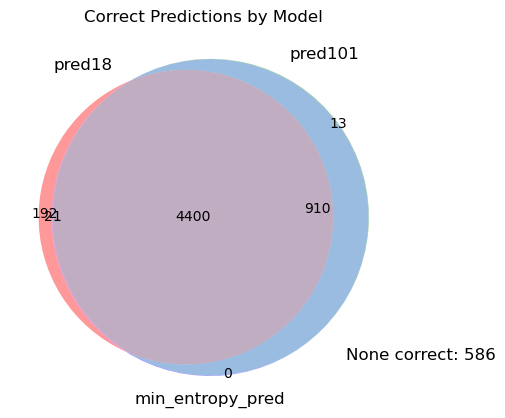

In [39]:
pred["min_entropy_pred"] = np.where(unc_pred["ent_18"]>unc_pred["ent_101"],pred["pred101"],pred["pred18"])
pred.head(1)
eval_pred(pred)
venn(pred[["pred18","pred101","min_entropy_pred","target"]])

**Method 2** We combine the predictions of models by assigning the other model's entropy as weights, i.e a model receives more weights when the other models is uncertain.

In [40]:
def vec_weighted_vote(pred1, pred2, weightvec1, weightvec2):
    weighted_pred = pred1.mul(weightvec1, axis=0) + pred2.mul(weightvec2, axis=0)
    return np.argmax(weighted_pred,axis=1)

pred["unc_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ent_101"], unc_pred["ent_18"])

display(pred.head(1))
eval_pred(pred)

,pred18,pred101,target,soft_vote,weighted_vote,min_entropy_pred,unc_weighted_vote
0,24,24,24,24,24,24,24


pred18 has accuracy 0.7535119242077752
pred101 has accuracy 0.8694870957203529
soft_vote has accuracy 0.8742241097680497
weighted_vote has accuracy 0.873734073832081
min_entropy_pred has accuracy 0.8707938582162692
unc_weighted_vote has accuracy 0.8727540019601437


,pred18,pred101,target,soft_vote,weighted_vote,min_entropy_pred,unc_weighted_vote,kl_weighted_vote
0,24,24,24,24,24,24,24,24


pred18 has accuracy 0.7535119242077752
pred101 has accuracy 0.8694870957203529
soft_vote has accuracy 0.8742241097680497
weighted_vote has accuracy 0.873734073832081
min_entropy_pred has accuracy 0.8707938582162692
unc_weighted_vote has accuracy 0.8727540019601437
kl_weighted_vote has accuracy 0.8753675269519765


/Users/timothyzhou/anaconda3/envs/cpsc340/lib/python3.11/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


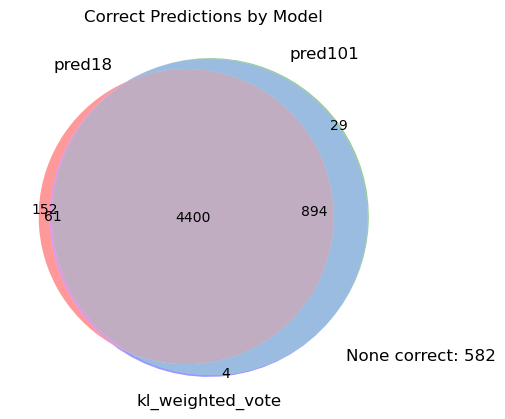

In [41]:
pred["kl_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"], unc_pred["kl_18_101"])
display(pred.head(1))
eval_pred(pred)
venn(pred[["target","pred18","pred101","kl_weighted_vote"]])